In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

In [2]:
plt.style.use("seaborn-whitegrid")

In [3]:
Ls = [20, 50, 100, 200]
L = 20
bs = [1.13, 1.15, 1.17, 1.21, 1.26, 1.3, 1.35, 1.45, 1.55, 1.65, 1.79, 1.85, 2.01]
Nfields = 40
CALC = 200

seeds = [5,58,4785,45895,1256,65478,854,126,42,1458,458,96324,985423,85456, 4585, 8956, 8596589,89589,74,658,84,845,9,55,489, 32,456,345,876,6, 456, 34,67,444,666, 5678, 98, 65, 389, 8765]
p_c = .9 # probability of being assigned strategy C

In [4]:
for L in Ls:
    for idx, seed in enumerate(seeds):
        np.random.seed(seed)
        np.save("fields/field_{}_{}.npy".format(L, idx), np.random.choice((0, 1), (L, L), p=(1-p_c, p_c)))

In [4]:
%load_ext cython

In [5]:
%%cython
import numpy as np
cimport cython

@cython.cdivision(True)
@cython.boundscheck(False)
def evolve(long[:, :] field, double b, long num_epoch=1):
    cdef:
        int L = field.shape[0]
        int x, y, x1, x2, x3, y1, y2, y3, i, j, bestX, bestY
        long[:, :] next_state = np.zeros((L, L), dtype=int)
        double[:, :] scores = np.zeros((L, L), dtype=float)
        double[:, :] _zeros = np.zeros((L, L), dtype=float)
        
    assert L != 0
    
    next_state = field.copy()
    
    for _ in range(num_epoch):
        scores[...] = _zeros
        for x in range(L):
            for y in range(L):
                x1, x2, x3 = (x-1)%L, x%L, (x+1)%L
                y1, y2, y3 = (y-1)%L, y%L, (y+1)%L
#                 return ((x1, x2, x3), (y1, y2, y3))
                scores[x, y] = (field[x1, y1] + field[x1, y2] + field[x1, y3] + field[x2, y1] + field[x2, y2] + field[x2, y3] + field[x3, y1] + field[x3, y2] + field[x3, y3])
                if field[x, y] == 0:
                    scores[x, y] *= b
#         return scores
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if scores[(x+i)%L, (y+j)%L] > scores[bestX, bestY]:
                            bestX = (x+i)%L
                            bestY = (y+j)%L

                next_state[x, y] = field[bestX, bestY]
        
        field = next_state.copy()
        
    return np.asarray(field)

In [6]:
density = []
for b in tqdm(bs):
    den = []
    for i in range(len(seeds)):
        field = np.load("fields/field_{}_{}.npy".format(L, i))
        d = []
        for _ in range(0, CALC):
            field = evolve(field, b)
            d.append(field.sum()/(1.*field.shape[0]*field.shape[1]))
        den.append(d)
    density.append(den)

100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


In [7]:
np.asarray(density)

(13, 40, 200)

<IPython.core.display.Javascript object>


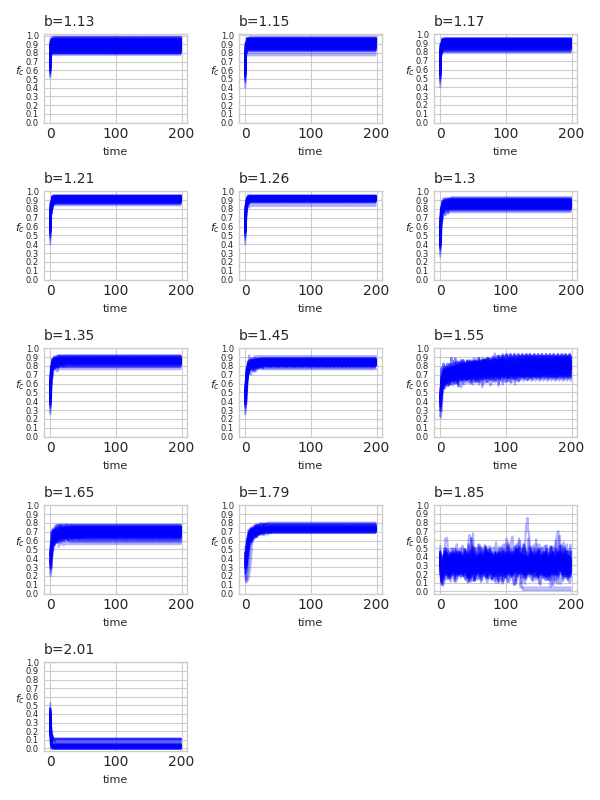

In [20]:
fig = plt.figure(figsize=(6, 8))
for i in range(len(bs)):
    ax = plt.subplot(5, 3, i+1, label="b={}".format(bs[i]))
    ax.set_title("b={}".format(bs[i]), loc="left", fontsize=10)
    for j in range(40):
        ax.plot(density[i][j], "b", alpha=.3)
    plt.xlabel('time', fontsize=8)
    plt.yticks(np.arange(0., 1.1, .1), fontsize=6)
    plt.ylabel("$f_c$", rotation=0, fontsize=8)
#     plt.show()
plt.tight_layout()
fig.savefig('biggraph.png', dpi=300)

2.01


<IPython.core.display.Javascript object>


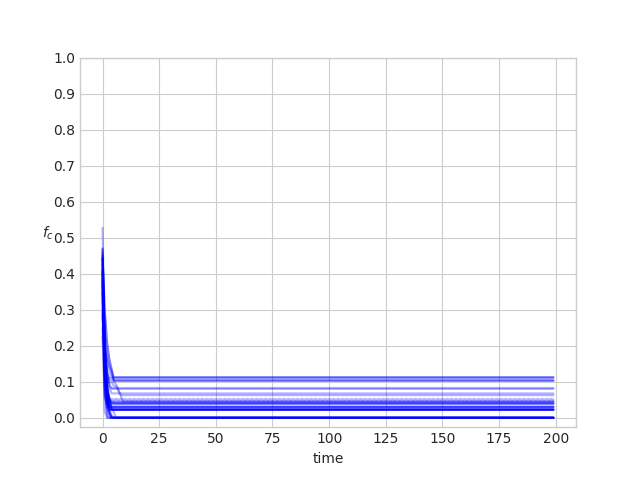

In [17]:
n=12
print(bs[n])
for i in range(40):
    plt.plot(density[n][i], "b", alpha=.3)
    plt.xlabel('time')
    plt.yticks(np.arange(0., 1.1, .1))
    plt.ylabel("$f_c$", rotation=0)